<a href="https://colab.research.google.com/github/sunnyl94/Data-Analysis-Folder/blob/main/Retail_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 마케팅 고객 데이터 분석

<!-- 출처 https://www.kaggle.com/datasets/darpan25bajaj/retail-case-study-data -->

In [1]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [2]:
# 필요한 library 설치
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='NanumBarunGothic')

import warnings
warnings.filterwarnings("ignore")

In [3]:
# 데이터 임포트
customer = pd.read_csv("/content/drive/MyDrive/workspace/Data Analysis/Retail Case Study/data/Customer.csv")
transaction = pd.read_csv("/content/drive/MyDrive/workspace/Data Analysis/Retail Case Study/data/Transactions.csv")
prod_info = pd.read_csv("/content/drive/MyDrive/workspace/Data Analysis/Retail Case Study/data/prod_cat_info.csv")

In [4]:
print("customer: ", customer.shape)
print("transaction: ", transaction.shape)
print("prod_info: ", prod_info.shape)

customer:  (5647, 4)
transaction:  (23051, 10)
prod_info:  (23, 4)


---
# **1. 데이터 전처리**



In [5]:
# DOB (Date of Birth) 컬럼이 object 타입으로 설정되어 있어 날짜로 변환 필요
customer.dtypes

customer_Id      int64
DOB             object
Gender          object
city_code      float64
dtype: object

In [6]:
customer["DOB"] = pd.to_datetime(customer["DOB"])
customer.dtypes

customer_Id             int64
DOB            datetime64[ns]
Gender                 object
city_code             float64
dtype: object

In [7]:
# null value가 없다
transaction.isnull().sum()

transaction_id      0
cust_id             0
tran_date           0
prod_subcat_code    0
prod_cat_code       0
Qty                 0
Rate                0
Tax                 0
total_amt           0
Store_type          0
dtype: int64

In [8]:
# tran_date 컬럼이 object 타입으로 설정되어 있어 날짜로 변환이 필요
transaction.dtypes

transaction_id        int64
cust_id               int64
tran_date            object
prod_subcat_code      int64
prod_cat_code         int64
Qty                   int64
Rate                  int64
Tax                 float64
total_amt           float64
Store_type           object
dtype: object

In [9]:
transaction["tran_date"] = pd.to_datetime(transaction['tran_date'])
transaction.dtypes

transaction_id               int64
cust_id                      int64
tran_date           datetime64[ns]
prod_subcat_code             int64
prod_cat_code                int64
Qty                          int64
Rate                         int64
Tax                        float64
total_amt                  float64
Store_type                  object
dtype: object

In [10]:
# null value가 없다
prod_info.isnull().sum()

prod_cat_code        0
prod_cat             0
prod_sub_cat_code    0
prod_subcat          0
dtype: int64

In [11]:
# 각 컬럼 타입들이 잘 매칭되어 있다
prod_info.dtypes

prod_cat_code         int64
prod_cat             object
prod_sub_cat_code     int64
prod_subcat          object
dtype: object

## 1.a 파생 데이터







데이터가 2014년도에 만들어진 데이터이기 떄문에 2014년도 기준 고객 (만)나이 컬럼을 생성해줄 필요가 있다



In [12]:
customer['age'] = 2014 - customer["DOB"].dt.year

> 주문 건수, 취소 건수, 상품 전환율을 분석하기 위해 거래 상태를 구분할 수 있는 컬럼이 필요

> transaction table에 "Order_status" 컬럼을 추가
*   상품이 취소 되었으면 "cancel"
*   상품이 주문 되었으면 "order"

In [ ]:
transaction["order_status"] = np.where(transaction["Qty"] < 0, "cancel", "order")
transaction.head()

In [77]:
transaction.shape

(23051, 14)



> transaction table에 "confirmed" 컬럼을 추가

1.   상품이 [주문 후 취소] 되었거나 혹은 원래 [취소] 상태였으면 되었으면 "cancel"
2.   상품이 주문 [완료] 되었으면 "confirmed"





In [ ]:
# 주문이 완전히 취소된 행만을 추출한 후 "Order_status"를 새로 추가할 "confirmed"라는 컬럼명으로 바꾼다
cancel_confirmed = transaction[transaction["order_status"] == "cancel"][["transaction_id", "order_status"]].drop_duplicates().rename(columns={"order_status":"confirmed"})

# transaction table과 cancel_confirmed table을 합쳐 주문 후 취소한 상품 표시
transaction = pd.merge(transaction, cancel_confirmed, on="transaction_id", how="left")

# NaN value를 주문 되었다는 "confirmed"로 바꾸기
transaction["confirmed"] = transaction["confirmed"].replace(np.nan, "confirm")

transaction.head()

In [16]:
num_cancel = transaction[transaction["order_status"] == "cancel"]["order_status"].count()
num_order = transaction[transaction["order_status"] == "order"]["order_status"].count()
num_confirm = transaction[transaction["confirmed"] == "confirm"]["confirmed"].count()

print(num_order, num_cancel, num_order - num_cancel, num_confirm)

20876 2175 18701 18819



> 문제: 총 주문 건수에서 총 취소 건수를 뺀 결과값과 "confirmed" 컬럼에서 확정된 총 주문수 불일치<br>
이상치 혹은 결측치가 존재한다는 뜻이기에 제거 필요




## 1.b 이상치 / 결측치 데이터 처리

### 1.b.i 이상치

In [76]:
transaction["transaction_id"].value_counts().head()

4170892941     4
426787191      4
32263938079    4
81802961273    3
74269001881    3
Name: transaction_id, dtype: int64



> 하나의 transaction id에 최대 2개 row가 존재할 수 있지만 확인 결과 3개 이상의 row가 있는것이 확인 됨




In [ ]:
# transaction id는 같아도 tran_date가 다를 수 있기 때문에 drop_duplicates()는 사용 불가
# transaction id와 order_status를 비교 후 중복으로 들어간 행만 제거 필요


# transaction id와 order_status의 내용을 합친 리스트를 만들고 transaction table에 추가
key = map(lambda id, status : str(id) + str(status), transaction["transaction_id"], transaction["order_status"])
transaction["key"] = list(key)
transaction.head()

In [19]:
# transaction table을 cust_id, transaction_id, tran_date 순으로 정렬 
transaction.sort_values(by=["cust_id", "transaction_id", "tran_date"], inplace=True, ignore_index=True)

In [20]:
# duplicate가 있는지 확인
# 1이면 중복이 아니고 0이면 중복
transaction["chk"] = np.where(transaction["key"] != transaction["key"].shift(-1), 1, 0)

# 1인것만 남기기
filtered_trans = transaction[transaction["chk"] == 1].reset_index(drop=True)

In [21]:
num_cancel = filtered_trans[filtered_trans["order_status"] == "cancel"]["order_status"].count()
num_order = filtered_trans[filtered_trans["order_status"] == "order"]["order_status"].count()
num_confirm = filtered_trans[filtered_trans["confirmed"] == "confirm"]["confirmed"].count()

print(num_order, num_cancel, num_order - num_cancel, num_confirm)

20876 2057 18819 18819


### 1.b.ii 결측치

In [22]:
# Gender와 city_code 컬럼에 각각 2개의 null value가 존재
customer.isnull().sum()

customer_Id    0
DOB            0
Gender         2
city_code      2
age            0
dtype: int64

In [23]:
# Gener는 M,F,none으로 세개의 범주를 만들어 결측치 해결
customer.fillna(value={"Gender":"none"}, inplace=True)

In [24]:
# city_code는 최빈값으로 결측치 해결
customer.fillna(value={"city_code":customer["city_code"].mode()[0]}, inplace=True)

## 1.c 테이블 조인

> Transaction Table안에 category code가 존재하지만 명칭이 없기 때문에 Transaction table과 prod_cat_info Table을 조인 필요



In [ ]:
filtered_trans.head()

In [ ]:
prod_info.head()

In [ ]:
# prod_cat_code 컬럼명은 같지만 prod_subcat_code 컬럼명은 다르기 때문에 조인을 쉽게 하기 위해 prod_info 테이블의 컬럼명을 transaction 테이블의 컬럼명과 똑같이 만들어 준다

prod_info.rename(columns= {"prod_sub_cat_code":"prod_subcat_code"}, inplace=True)
prod_info.head()

In [ ]:
# prod_info 테이블과 transaction 테이블 조인 진행

new_data = pd.merge(
    left = filtered_trans,
    right = prod_info,
    on = ["prod_cat_code", "prod_subcat_code"],
    how = "left"
)

new_data.head()

---

# **2. 데이터 분석**

## 2.a 상품 전환율

> 주문 거래 건 중 취소가 발생되지 않고 구매가 확정된 거래 건 비중

**질문**
> 1. 고관여 상품군의 상품 전환율이 높을 것인가?<br>
        고관여 상픔의 특징
        1. 구매 전 상품에 대한 탐색 과정이 길다
        2. 거래 비용 발생이 상대적으로 크다



In [ ]:
# prod_cat별 최종 구매 및 취소 수
cvr = new_data.groupby(["prod_cat"])["confirmed"].value_counts().unstack()

# 전체 구매
cvr["total"] = new_data.groupby(["prod_cat"])["confirmed"].count()

# 모든 제품을 위한 total 만들기
sum = cvr.sum()
sum.name = "Total"

cvr = cvr.append(sum.transpose())

# 상품 전환율
cvr["CVR(%)"] = ((cvr["confirm"] / cvr["total"]) * 100).round(1)

In [ ]:
# prod_subcat별 최종 구매 및 취소 수
cvr_subcat = new_data.groupby(["prod_cat", "prod_subcat"])["confirmed"].value_counts().unstack()

# 전체 구매
cvr_subcat["total"] = new_data.groupby(["prod_cat", "prod_subcat"])["confirmed"].count()

# 상품 전환율
cvr_subcat["CVR(%)"] = ((cvr_subcat["confirm"] / cvr_subcat["total"]) * 100).round(1)

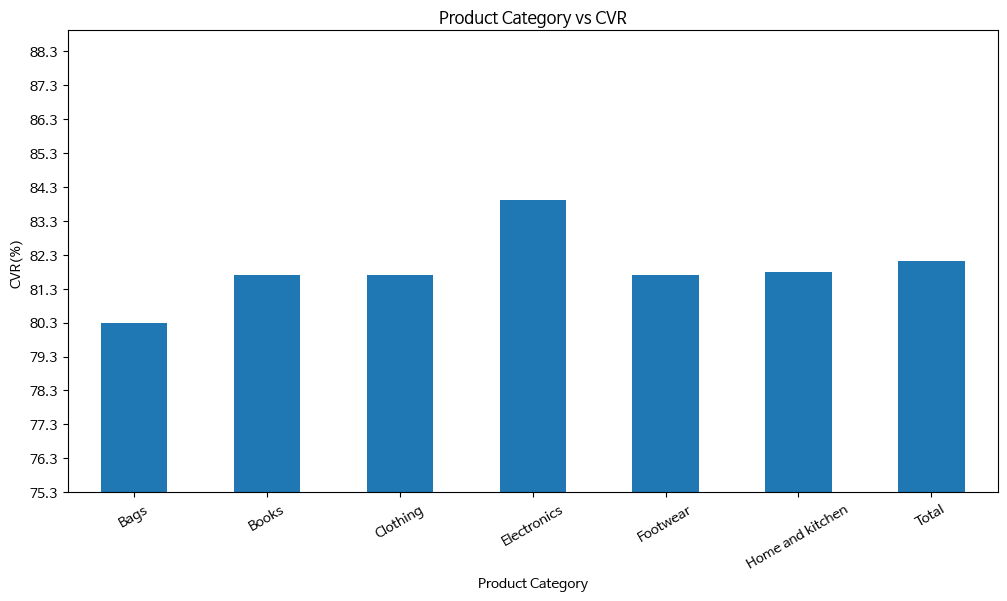

In [31]:
cvr["CVR(%)"].plot(kind="bar", figsize=(12, 6))

plt.xticks(rotation=30, horizontalalignment="center")
plt.ylim(min(cvr["CVR(%)"]) - 5, max(cvr["CVR(%)"])+5)
plt.yticks(np.arange(min(cvr["CVR(%)"] - 5), max(cvr["CVR(%)"]) + 5, 1))
plt.xlabel("Product Category")
plt.ylabel("CVR(%)")
plt.title("Product Category vs CVR")

plt.show()

In [32]:
cvr_subcat.index

MultiIndex([(            'Bags',                'Mens'),
            (            'Bags',               'Women'),
            (           'Books',            'Academic'),
            (           'Books',            'Children'),
            (           'Books',              'Comics'),
            (           'Books',                 'DIY'),
            (           'Books',             'Fiction'),
            (           'Books',         'Non-Fiction'),
            (        'Clothing',                'Kids'),
            (        'Clothing',                'Mens'),
            (        'Clothing',               'Women'),
            (     'Electronics',     'Audio and video'),
            (     'Electronics',             'Cameras'),
            (     'Electronics',           'Computers'),
            (     'Electronics',             'Mobiles'),
            (     'Electronics', 'Personal Appliances'),
            (        'Footwear',                'Kids'),
            (        'Footwear'

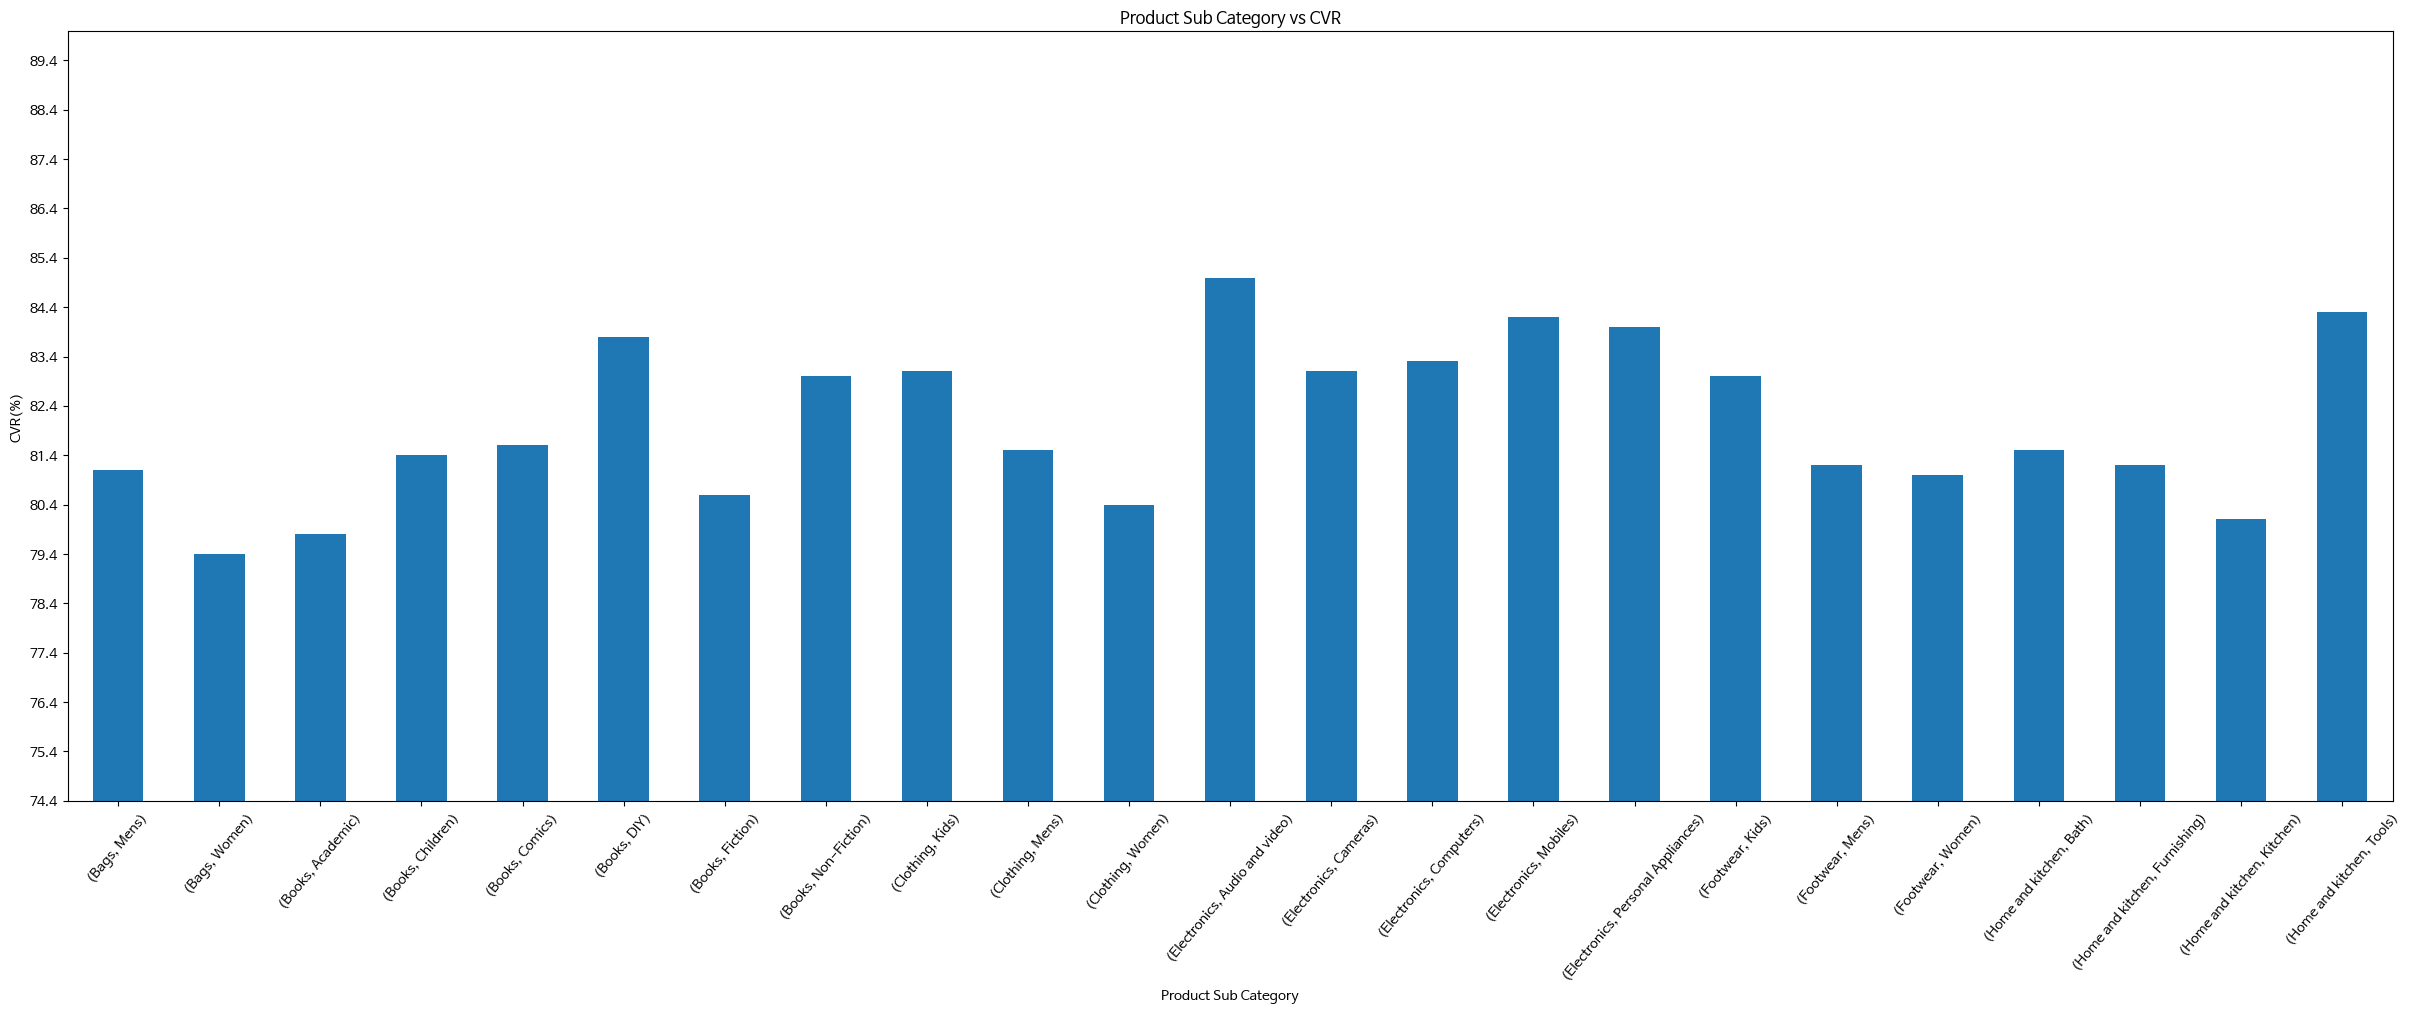

In [33]:
cvr_subcat["CVR(%)"].plot(kind="bar", figsize=(30, 10))

plt.xticks(rotation=50)
plt.ylim(min(cvr_subcat["CVR(%)"]) - 5, max(cvr_subcat["CVR(%)"])+5)
plt.yticks(np.arange(min(cvr_subcat["CVR(%)"] - 5), max(cvr_subcat["CVR(%)"]) + 5, 1))
plt.xlabel("Product Sub Category")
plt.ylabel("CVR(%)")
plt.title("Product Sub Category vs CVR")

plt.show()

In [34]:
min_cvr = min(cvr_subcat["CVR(%)"])
max_cvr = max(cvr_subcat["CVR(%)"])
avg_cvr = cvr["CVR(%)"][-1]

print("최대: ", max_cvr)
print("최소: ", min_cvr)
print("평균: ", avg_cvr)
print("최대 - 최소: ", round(max_cvr - min_cvr,2))
print("최대 - 평균: ", round(max_cvr - avg_cvr,2))
print("최소 - 평균: ", round(min_cvr - avg_cvr,2))

최대:  85.0
최소:  79.4
평균:  82.1
최대 - 최소:  5.6
최대 - 평균:  2.9
최소 - 평균:  -2.7


**결과 해석**
> * 상품 전환율이 높은 대 카테고리는 "Electronics"이며 서브 카테고리는 "Audio and video"이다
    * 이는 고관여 상품으로 분류되는 Electronics 카테고리가 상품 전환율이 크다라는 가설을 뒷받침 할 수 있는 근거이다.
    * 하지만 상품 전환율이 가장 높은 카테고리와 낮은 카테고리의 차이가 **5.6%**로 그 차이가 작고, 평균과의 편차도 작은 편이다.
* 그러므로 카테고리간의 상품 전환율 차이가 유의미하다고 보기 힘들다.

**새로운 질문**
> 1. 상품 전환율이 높았던 "Electronics" 카테고리가 다른 카테고리 대비 평균 판매가가 높은가 (고관여 상품인가)?
2. 평균 판매가와 상품 전환율 간 관계가 존재하는가?
    * 가격이 높을수록 상품 전환율이 높아지는지?










In [ ]:
# CVR과 Rate의 랭크 구하기
cvr_new = pd.pivot_table(new_data,
               index=['prod_cat', 'prod_subcat'],
               columns=['confirmed'],
               values=["transaction_id", 'Rate'],
               aggfunc={'transaction_id':'count',
                        'Rate': np.mean})


# CVR 구하기
cvr_new["CVR(%)"] = ((cvr_new[('transaction_id', 'confirm')] / (cvr_new[('transaction_id', 'cancel')] + cvr_new[('transaction_id', 'confirm')])) * 100).round(1)

# CVR 순위
cvr_new["Rank CVR"] = cvr_new['CVR(%)'].rank(method='first', ascending=False)

# 평균 판매가 순위
cvr_new["Rank Rate"] = cvr_new[('Rate', 'confirm')].rank(method='first', ascending=False)
cvr_new.sort_values(['Rank CVR'], ascending=True, inplace=True)

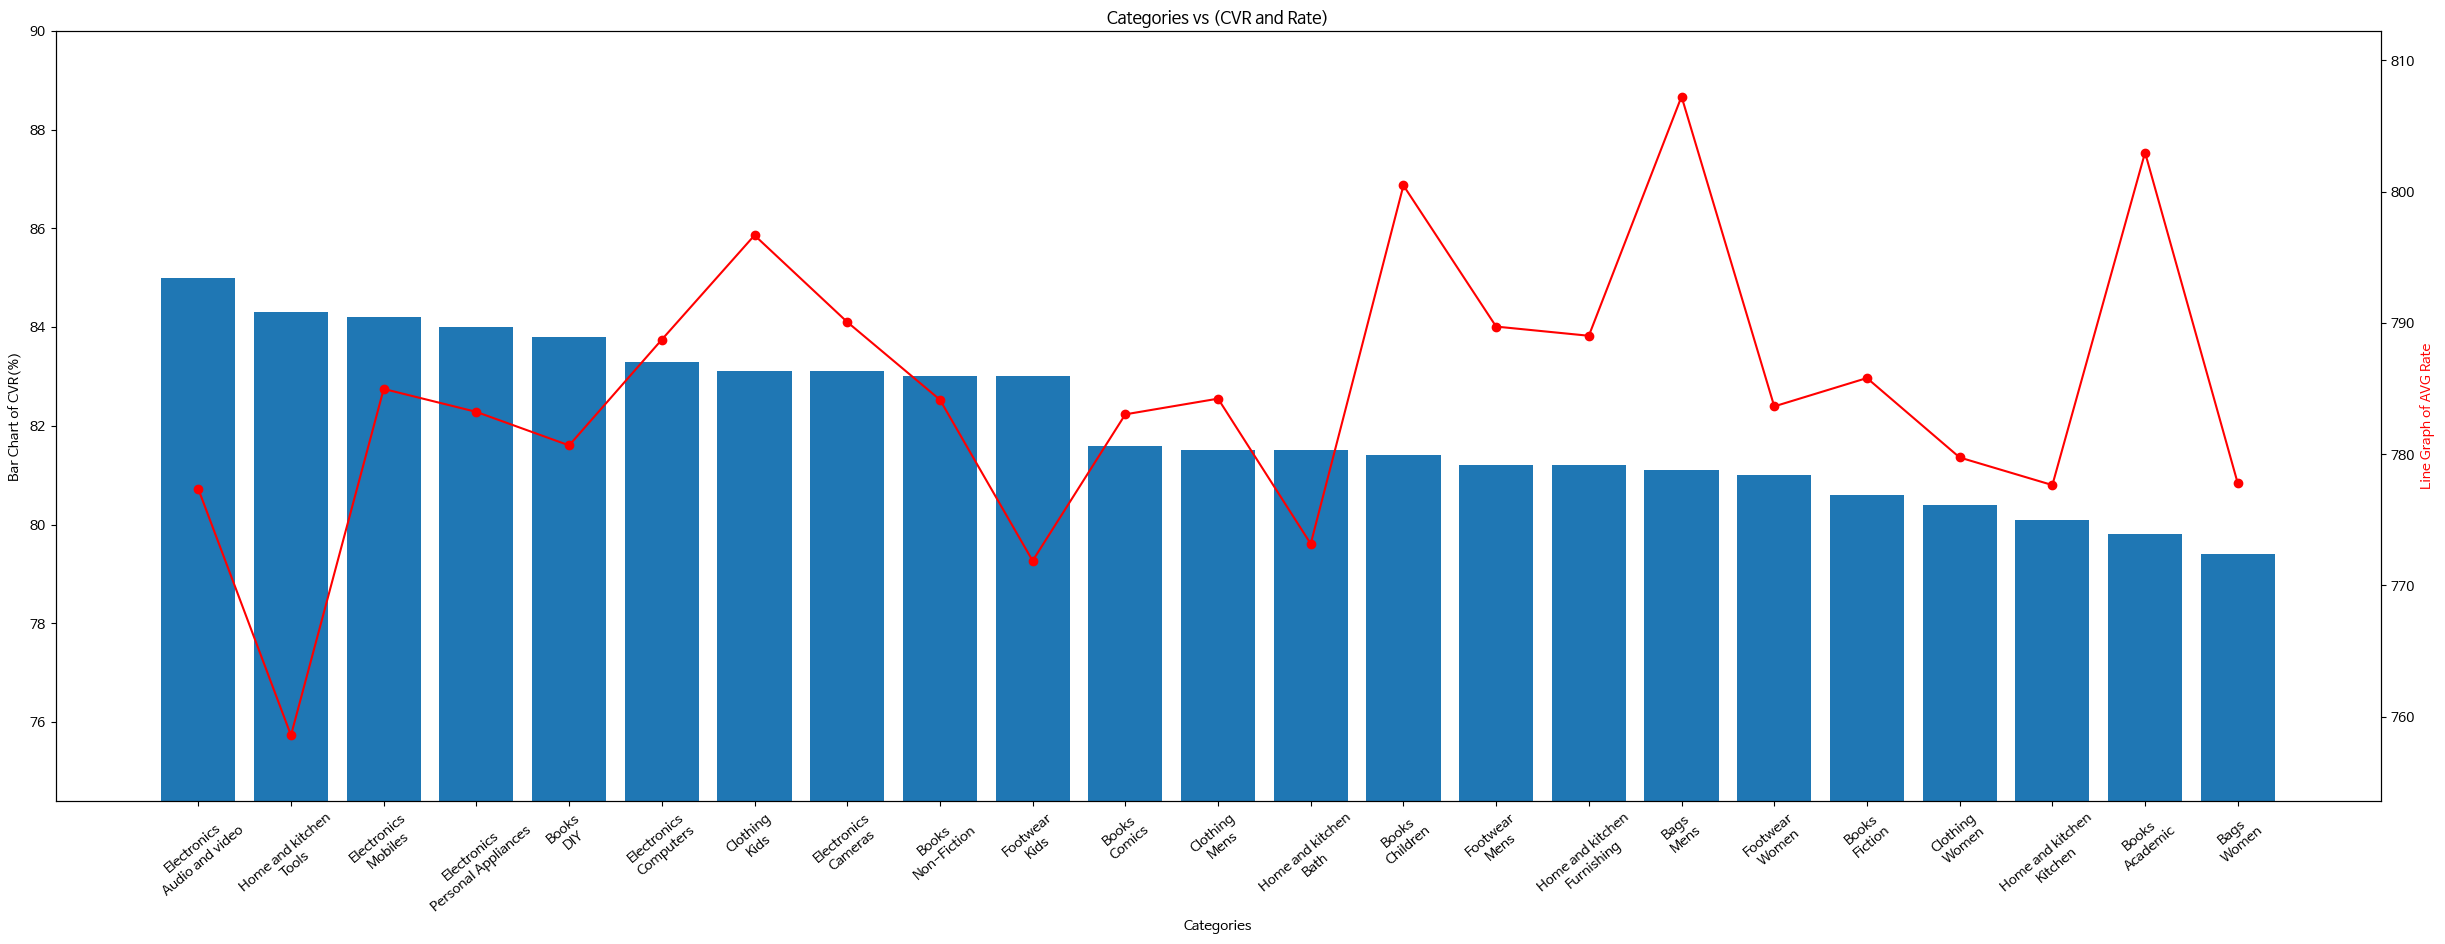

In [36]:
fig, ax1 = plt.subplots(figsize=(30,10))

x = cvr_new.index
x_cats = [f'{cat1}\n{cat2}' for cat1, cat2 in x]

y1 = cvr_new["CVR(%)"]
y2 = cvr_new[('Rate', 'confirm')]

x_pos = np.arange(len(x))
ax1.bar(x_pos, y1)
ax1.set_ylabel('Bar Chart of CVR(%)')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(x_cats, rotation=40)
ax1.set_ylim(y1.min() - 5, y1.max() + 5)

ax2 = ax1.twinx()
ax2.plot(x_pos, y2, color='red', marker='o')
ax2.set_ylabel('Line Graph of AVG Rate', color='red')
ax2.set_ylim(y2.min() - 5, y2.max() + 5)

ax1.set_xlabel('Categories')
ax2.set_title('Categories vs (CVR and Rate)')

plt.show()


**결과 해석**



> 1. 고관여 상품군인 "Electronics"의 평균 판매가는 다른 카테고리의 평균 판매가 대비 높지 않다.
    * Electronics (Audio and video)의 상품 전환율은 1위이지만 평균 판매가는 20위이다
2. 평균 판매가와 상품 전환율 간 특별한 상관 관계가 보이지 않는다







## 2.b 카테고리별 매출

### 2.b.i CAGR (기하평균)

1. 각 카테고리 매해의 매출액 성장률

In [37]:
df_copy = new_data.copy()

# 2014년도는 2월달 데이터밖에 없기 때문에 year column을 만들어주고 2014년도 데이터는 제외한다
df_copy['year'] = df_copy['tran_date'].dt.year
years = [2011, 2012, 2013]
df_copy = df_copy[df_copy['tran_date'].dt.year.isin(years)]

In [ ]:
# 카테고리별 연매출
cagr_table = pd.pivot_table(df_copy, 
                            index=['year'],
                            columns=["prod_cat"],
                            values=['total_amt'],
                            aggfunc='sum'
                            )

In [ ]:
# 카테고리 별 CAGR
cagr = round(((cagr_table.iloc[-1] / cagr_table.iloc[0])**(1/len(cagr_table)) - 1) * 100, 2)


**결과해석**
> 2011년부터 2013년까지의 카테고리별 CAGR를 구했을 때 **Clothing** 카테고리가 **5.78%**로  매출액 성장률이 제일 높았으며 **Book** 카테고리가 **-0.09%**로 성장률이 제일 저조했다.



### 2.b.ii 분산과 표준편차

**질문**


> 각 카테고리별 월평균 매출 추이에 대한 해석
1. 가장 월평균 매출익이 높은 카테고리는?
2. 카테고리별 월평균 매출액의 분산과 표준 편차는?
3. RSD(변동계수)를 이용한 해석?



In [40]:
# month column 추가
df_copy['month'] = df_copy['tran_date'].dt.month

In [ ]:
# 카테고리별 년,월 매출
cagr_table_by_month = pd.pivot_table(df_copy, 
                            index=['year', 'month'],
                            columns=["prod_cat"],
                            values=['total_amt'],
                            aggfunc='sum'
                            )


In [42]:
mean_ = round(cagr_table_by_month.mean(), 3)
var_ = cagr_table_by_month.var()
std_ = cagr_table_by_month.std()
rsd_ = round(std_/mean_, 3)

In [ ]:
stats_df = pd.concat([mean_, var_, std_, rsd_], axis=1)
stats_df.columns = ['Mean', 'Variance', 'Std. Deviation', 'RSD']


**결과 해석**

1. 월매출 평균이 제일 높은 카테고리는 **Books** 카테고리이며, 제일 낮은 카테고리는 **Bags** 카테고리이다.
2. **표준 편차**로만 보았을 때 Book 카테고리의 매출액 변동성이 가장 큰 것처럼 보이지만 **RSD**를 이용하였을 때는 Book 카테고리는 매출액 변동성이 낮으면서 월평균 매출액이 가장 큰 카테고리다.
3. **따라서 Books 카테고리가 매출에 기여도가 크면서 안정적으로 매출이 발생하는 주력 카테고리라고 해석된다.**



## 2.c 고객 추천 (Not available ATM)

In [44]:
df_copy2 = new_data.copy()

# prod_cat과 prod_subcat을 합친 컬럼 만들기
df_copy2['category'] = df_copy2['prod_cat'] + '-' + df_copy2['prod_subcat']

# cust_id명을 customer 테이블의 customer_id와 똑같이 만들기
df_copy2.rename(columns={'cust_id':'customer_Id'}, inplace=True)

In [ ]:
# transaction 테이블과 customer 테이블 조인 진행
# customer 테이블에서 gender와 age 컬럼만 가져오기

df2 = pd.merge(
    left = df_copy2,
    right = customer[['customer_Id', 'Gender', 'age']],
    on = ["customer_Id"],
    how = "left"
)

In [46]:
corr_pivot_table = pd.pivot_table(df2, 
                            index=['customer_Id'],
                            columns=["category"],
                            values=['transaction_id'],
                            aggfunc='count'
                            ).fillna(0)

## 2.d Z 차트


**질문**
> Z 차트를 이용한 2013년 매출추이 시계열 분석 및 해석
> 1. 월별 매출
> 2. 누계 매출
> 3. 이동 합계



In [47]:
# 카테고리별 월 매출
sales_by_month = pd.pivot_table(df_copy, 
                            index=['year', 'month'],
                            columns=["prod_cat"],
                            values=['total_amt'],
                            aggfunc='sum'
                            )

In [48]:
# 2013년 월별 매출
sales_2013 = sales_by_month.loc[2013]

# 2013년 누계 매출
cum_sales = sales_2013.cumsum()

# 2013년 이동 합계
moving_sum = sales_by_month.rolling(window=12).sum().loc[2013]

In [ ]:
# 카테고리별 월별 매출, 누계 매출, 이동 합계를 한 테이블에 합치기
combined_df = pd.DataFrame()
col_names = []
for col in moving_sum.columns:
    new_cols = pd.MultiIndex.from_product([[col[1]], ['월별 매출','누계 매출', '이동 합계']])
    new_df = pd.concat([sales_2013[col], cum_sales[col], moving_sum[col]], axis=1)
    new_df.columns = pd.MultiIndex.from_tuples(new_cols)
    combined_df = pd.concat([combined_df, new_df], axis=1)


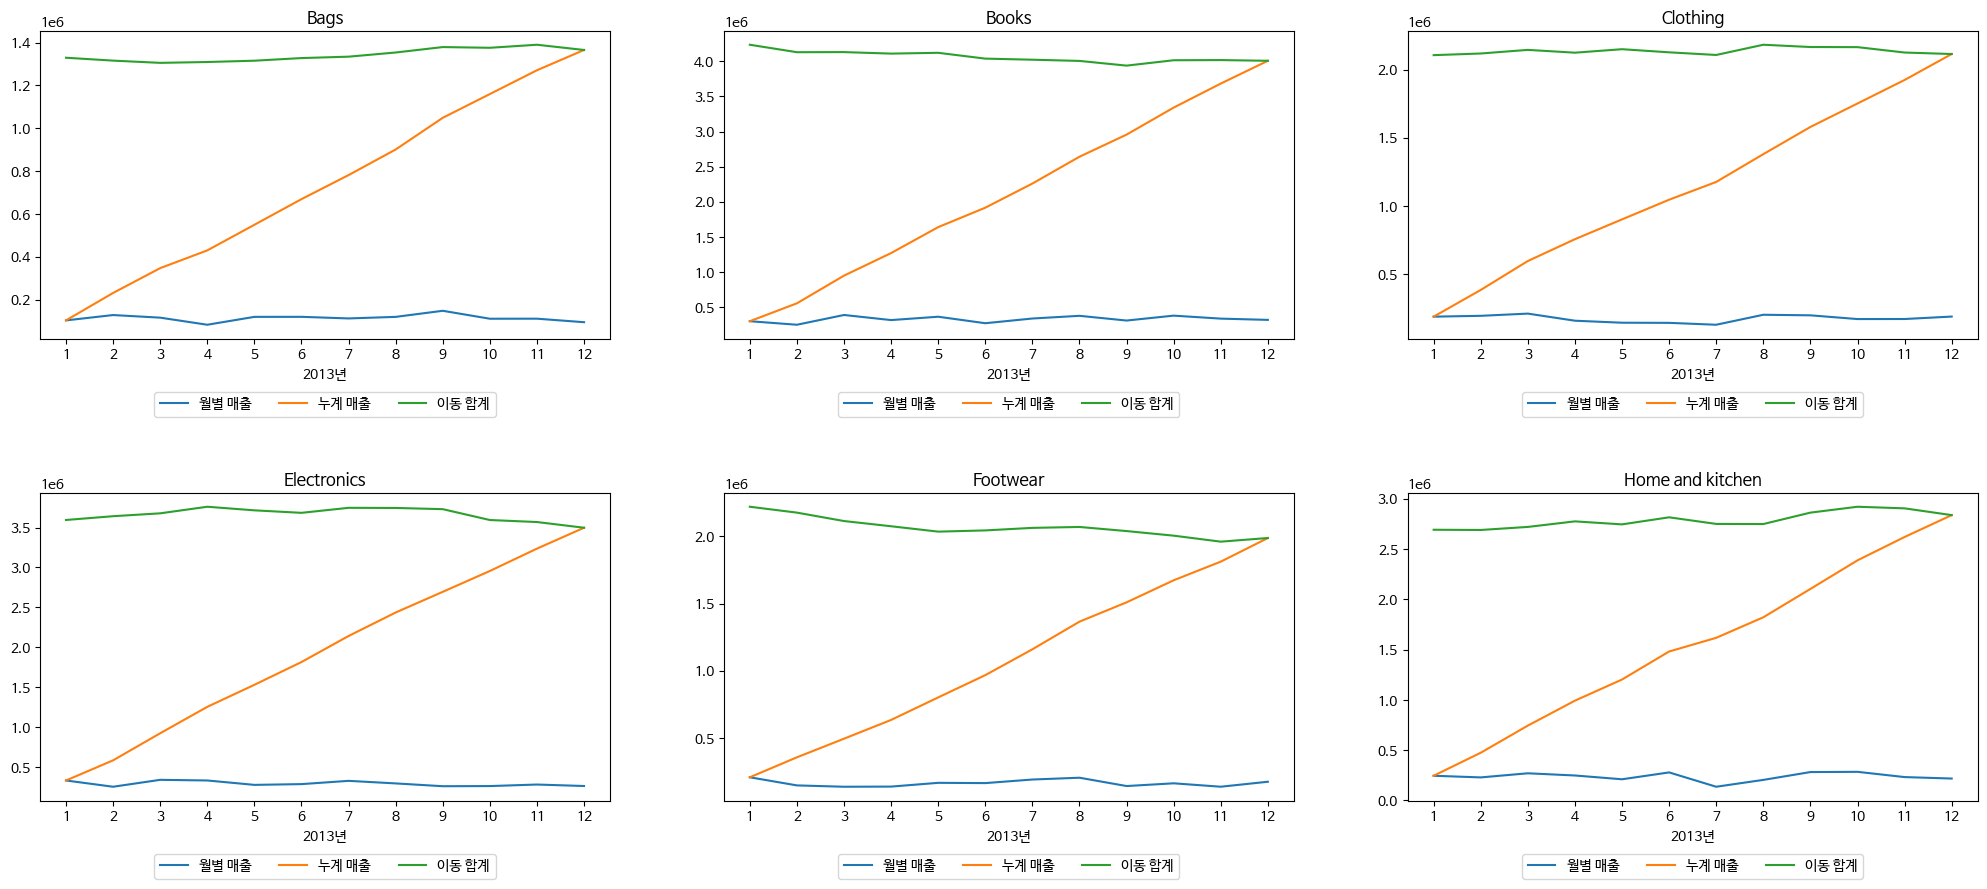

In [50]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes[0, 0].plot(combined_df.index, combined_df[('Bags', '월별 매출')], label='월별 매출')
axes[0, 0].plot(combined_df.index, combined_df[('Bags', '누계 매출')], label='누계 매출')
axes[0, 0].plot(combined_df.index, combined_df[('Bags', '이동 합계')], label='이동 합계')
axes[0, 0].set_title("Bags")
axes[0, 0].set_xticks(range(1,13,1))
axes[0, 0].set_xlabel('2013년')
axes[0, 0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

axes[0, 1].plot(combined_df.index, combined_df[('Books', '월별 매출')], label='월별 매출')
axes[0, 1].plot(combined_df.index, combined_df[('Books', '누계 매출')], label='누계 매출')
axes[0, 1].plot(combined_df.index, combined_df[('Books', '이동 합계')], label='이동 합계')
axes[0, 1].set_title("Books")
axes[0, 1].set_xticks(range(1,13,1))
axes[0, 1].set_xlabel('2013년')
axes[0, 1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

axes[0, 2].plot(combined_df.index, combined_df[('Clothing', '월별 매출')], label='월별 매출')
axes[0, 2].plot(combined_df.index, combined_df[('Clothing', '누계 매출')], label='누계 매출')
axes[0, 2].plot(combined_df.index, combined_df[('Clothing', '이동 합계')], label='이동 합계')
axes[0, 2].set_title("Clothing")
axes[0, 2].set_xticks(range(1,13,1))
axes[0, 2].set_xlabel('2013년')
axes[0, 2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

axes[1, 0].plot(combined_df.index, combined_df[('Electronics', '월별 매출')], label='월별 매출')
axes[1, 0].plot(combined_df.index, combined_df[('Electronics', '누계 매출')], label='누계 매출')
axes[1, 0].plot(combined_df.index, combined_df[('Electronics', '이동 합계')], label='이동 합계')
axes[1, 0].set_title("Electronics")
axes[1, 0].set_xticks(range(1,13,1))
axes[1, 0].set_xlabel('2013년')
axes[1, 0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

axes[1, 1].plot(combined_df.index, combined_df[('Footwear', '월별 매출')], label='월별 매출')
axes[1, 1].plot(combined_df.index, combined_df[('Footwear', '누계 매출')], label='누계 매출')
axes[1, 1].plot(combined_df.index, combined_df[('Footwear', '이동 합계')], label='이동 합계')
axes[1, 1].set_title("Footwear")
axes[1, 1].set_xticks(range(1,13,1))
axes[1, 1].set_xlabel('2013년')
axes[1, 1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

axes[1, 2].plot(combined_df.index, combined_df[('Home and kitchen', '월별 매출')], label='월별 매출')
axes[1, 2].plot(combined_df.index, combined_df[('Home and kitchen', '누계 매출')], label='누계 매출')
axes[1, 2].plot(combined_df.index, combined_df[('Home and kitchen', '이동 합계')], label='이동 합계')
axes[1, 2].set_title("Home and kitchen")
axes[1, 2].set_xticks(range(1,13,1))
axes[1, 2].set_xlabel('2013년')
axes[1, 2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)


**결과 해석**

> Bags와 Home and kitchen 카테고리는 점차적으로 매출이 **상승**<br>
> Clothing과 Electronics는 월별로는 차이가 있지만 전반적으로 매출이 **보합세**.<br>
> Books와 Footwear는 연초보다 연말에 매출이 **하락**.

## 2.e ABC 매출 등급 분석

>2013년 매출 등급 (누적 구성비 기준)
>>A등급 : 상위 50%<br>
>>B등급 : 상위 80%<br>
>>C등급 : 상위 100%

In [51]:
# 카테고리별 월 매출
df_2013 = df_copy[df_copy["year"] == 2013]

abc_table = pd.pivot_table(df_2013, 
                            index=['Store_type', 'prod_cat'],
                            values=['total_amt'],
                            aggfunc='sum'
                            )

**결과 해석**


> 1. 총 매출의 50%를 차지하는 A등급 카테고리는 총 7개로 그 중 5개는 온라인 **e-shop**에서 발생
> 2. 그 중 e-shop에서 생긴 **Books** 카테고리는 구성비가 10.7%를 차지하며 제일 매출 기여도가 높다
* 판매 촉진을 위한 광고비를 지출해야 한다면, e-shop에서의 광고, 특히 주력 카테고리인 Books와 Electronics을 중심으로 예산을 편성하여 운영
* 균형있는 매출을 위해 Bags와 Footwear 카테고리에 대해 매출 활성화 전략 필요



## 2.f 구매주기 경과 고객 추출 (CRM)

1. 각 고객의 구매주기 계산
2. 구매주기가 경과일이 앞뒤 30일인 고객 추출 (현재 날짜가 2014.03.01이라고 가정)

In [52]:
# 현재 날짜
today = '2014-03-01'

In [53]:
# 구매확정 거래건 대상 분석
df_copy3 = df_copy[df_copy['confirmed'] == 'confirm'].drop('chk', axis=1).sort_values(['cust_id', 'tran_date'])

# cust_id가 달라지면 1을 반환 (chk가 1인 행은 해당 고객의 최종 구매일)
df_copy3['chk'] = np.where(df_copy3['cust_id'] != df_copy3['cust_id'].shift(-1), 1, 0)

# cust_id와 tran_date를 하나로 묶어 구분할 수 있는 고유 key값 생성하고 중복이 아닌 구매일수 계산
key = map(lambda id, date : str(id) + '-' + str(date.strftime("%Y-%m-%d")), df_copy3["cust_id"], df_copy3["tran_date"])
df_copy3["key"] = list(key)
df_copy3['구매일수'] = np.where(df_copy3['key'] != df_copy3['key'].shift(-1), 1, 0)

# 누적 구매일수
df_copy3['누적 구매일수'] = df_copy3.groupby('cust_id')['구매일수'].cumcount() + 1

# diff로 각 구매일수간의 가격을 구한 후 NaT를 0초로 처리한 후 모든 수 int 타입으로 변경
df_copy3['구매일수 간격'] = df_copy3.groupby('cust_id')['tran_date'].diff().fillna(pd.Timedelta(seconds=0)).dt.days.astype(int)

# 최종 구매일자 - 최초 구매일자 계산
df_copy3['최종-최초'] = df_copy3.groupby('cust_id')['구매일수 간격'].cumsum()

In [54]:
# 고객의 마지막 거래건 추출 & 누적 구매일수가 1인 행은 최종 간격이 0이기 때문에 무시
# 누적 구매일수와 구매 최종 간격 값 가져오기

cycle_df = pd.pivot_table(df_copy3[(df_copy3['chk'] == 1) & (df_copy3['누적 구매일수'] != 1)],
               index=['cust_id', 'tran_date'],
               values=['누적 구매일수', '최종-최초'],
               aggfunc=['sum']
               )

# 구매 간격 / (누적 구매일수 - 1)를 구해서 구매주기 구하기
cycle_df['구매주기'] = cycle_df[('sum','최종-최초')] / (cycle_df[('sum','누적 구매일수')] - 1)

# 최종 구매일자에서 구매주기를 더해 다음 구매 예상일 구하기
cycle_df['구매 예상일'] = cycle_df.index.get_level_values('tran_date') + pd.to_timedelta(cycle_df['구매주기'], unit='d')
cycle_df['구매 예상일'] = cycle_df['구매 예상일'].apply(lambda x: x.strftime('%Y-%m-%d'))

# 현재 날짜가 2014.03.01이라는 가정하에 날짜 경과일수 구하기
# 계산하기 쉽게 int로 변환
# 현재 날짜보다 전이면 마이너스, 지났다면 플러스로 표현
cycle_df['경과일수'] = pd.to_datetime(today) - pd.to_datetime(cycle_df['구매 예상일'])
cycle_df['경과일수'] = cycle_df['경과일수'].dt.days.astype(int)

In [ ]:
# 경과일수가 30일보다 크거나 작은 고객들만 추출
cycle_df[(cycle_df['경과일수'] <= 30) & (cycle_df['경과일수'] >= -30)]

**결과 해석**
1. 현재일이 2014년 03월 01일이라는 가정하에 구매 예상일 경과일수가 30일 전후인 고개들만 추출한 결과 총 **486**명이 추출됨
2. 해당 고객들에게 푸쉬 알림을 보내 구매 전환을 **유도**


---

# **3. 퍼널 분석**

> 전체 서비스에 가입한 고객중 2013년 하반기 (7월~12월) 기간 동안 구매한 고객과 상품을 취소하지 않고 구매를 확정한 고객의 퍼널별 실적 차트

## 3.a 퍼널 데이터 전처리

In [56]:
df_copy4 = new_data.copy()

# 2013년 하반기 (7월~12월) 구매고객
df_copy4 = df_copy4[(df_copy4["tran_date"] >= '2013-07-01') & (df_copy4["tran_date"] < '2014-01-01')]

In [57]:
# 전체 고객 수
len_customer = len(customer)

# 2013 하반기 구매 고객 수
first_funnel = len(pd.pivot_table(df_copy4,
                                index=["cust_id"],
                                values=["transaction_id"],
                                aggfunc=["count"]))

# 2013 하반기 구매 최종 확정 고객 수
second_funnel = len(pd.pivot_table(df_copy4[df_copy4['confirmed'] == 'confirm'],
                                index=["cust_id"],
                                values=["transaction_id"],
                                aggfunc=["count"]))

# 첫번째 퍼널 전환율
first_funnel_ratio = round((first_funnel / len_customer)*100, 1)

# 두번째 퍼널 전환율
second_funnel_ratio = round((second_funnel / first_funnel)*100, 1)

In [58]:
data = [[len_customer, 0], [first_funnel, first_funnel_ratio], [second_funnel, second_funnel_ratio]]
index = ['전체 가입자', '2013 하반기 구매고객수', '2013 하반기 구매확정 고객수']
df_funnel = pd.DataFrame(data, index=index, columns=['고객수', '전환율(%)'])

# 비대상 고객의 수 계산
df_funnel['비대상'] = df_funnel['고객수'].shift(1) - df_funnel['고객수']
df_funnel['비대상'] = df_funnel['비대상'].fillna(0)
df_funnel

,고객수,전환율(%),비대상
전체 가입자,5647,0.0,0.0
2013 하반기 구매고객수,2591,45.9,3056.0
2013 하반기 구매확정 고객수,2394,92.4,197.0


## 3.b 퍼널 분석 시각화

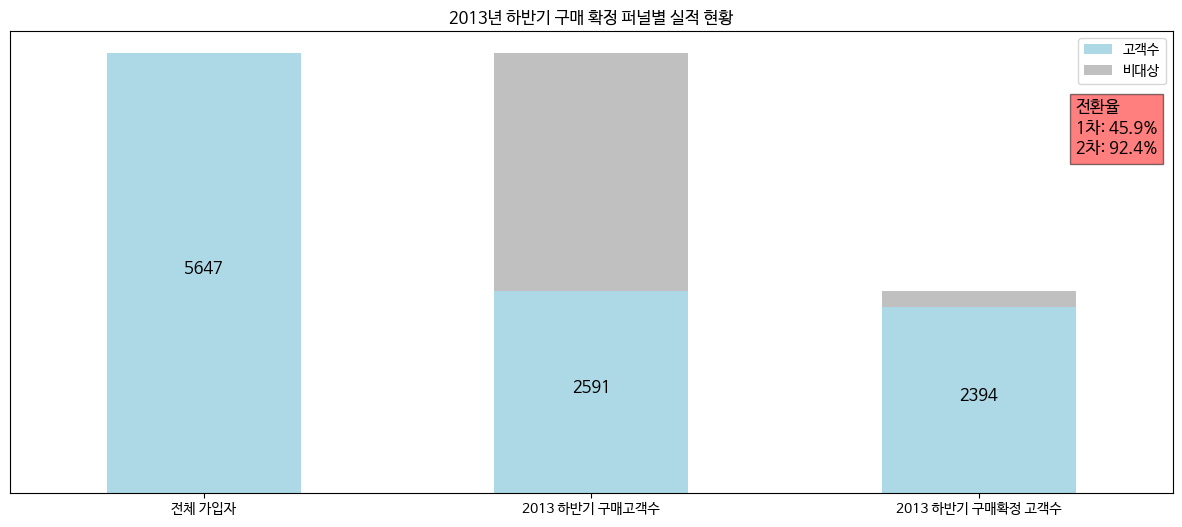

In [59]:
fig, ax = plt.subplots(figsize=(15, 6))

df_funnel[["고객수", "비대상"]].plot(kind='bar', stacked=True, color=['#ADD8E6', '#C0C0C0'], ax=ax)

ax.set_xticklabels(df_funnel.index, rotation=0)
ax.set_title("2013년 하반기 구매 확정 퍼널별 실적 현황")
ax.set_yticks([])

for i, val in enumerate(df_funnel['고객수']):
    ax.annotate(str(val), xy=(i, val/2), ha='center', fontsize=12)

plt.text(2.25, 4300,
         f'전환율\n1차: {df_funnel["전환율(%)"][1]}%\n2차: {df_funnel["전환율(%)"][2]}%',
         ha='left', va='bottom', fontsize=12,
         bbox=dict(facecolor='red', alpha=0.5))

plt.show()

**결과 해석**<br>
> 2013년 하반기에는 **첫번째 퍼널**에서 전체 가입자 중 **45.9%**에 해당하는 2591명이 구매로 전환되었고 **두번째 퍼널**에서 그중 **92.4%**에 해당하는 2394명이 구매확정으로 전환되었다



---


# **4. 코호트 분석**

* 2012년 각 고객이 첫구매한 월을 기준으로 코호트 생성<br>
* 첫구매 이후 경과월수별 평균 구매 유지율 코호트 분석 

## 4.a 코호트 데이터 전처리

In [60]:
import seaborn as sns

# 2012년 고객 구매 데이터 & 구매확정 데이터 추출
cohort_df = new_data[(new_data['tran_date'] >= '2012-01-01') & (new_data['tran_date'] < '2013-01-01') & (new_data['confirmed'] == 'confirm')]

# tran_date에서 월 추출
cohort_df['month'] = cohort_df['tran_date'].dt.month

# 첫 구매일의 월별 코호트 생성
cohort_df['cohort'] = cohort_df.groupby('cust_id')['month'].transform('min')

# 첫 구매일 월부터 경과 월수 계산
cohort_df['months_since_first_purchase'] = cohort_df['month'] - cohort_df['cohort']

# 각 코호트 경과 월수에 해당하는 고객 수 계산
cohort_data = cohort_df.groupby(['cohort', 'months_since_first_purchase'])['cust_id'].nunique().reset_index()

# 각 코호트의 고객수 계산
cohort_sizes = cohort_df.groupby('cohort')['cust_id'].nunique()

# 경과월수별 구매 유지율 계산
cohort_data = cohort_data.merge(cohort_sizes, on='cohort')
cohort_data['retention'] = cohort_data['cust_id_x'] / cohort_data['cust_id_y']

## 4.b 코호트 분석 시각화

### 4.b.i 전체 구매 유지율 히트맵

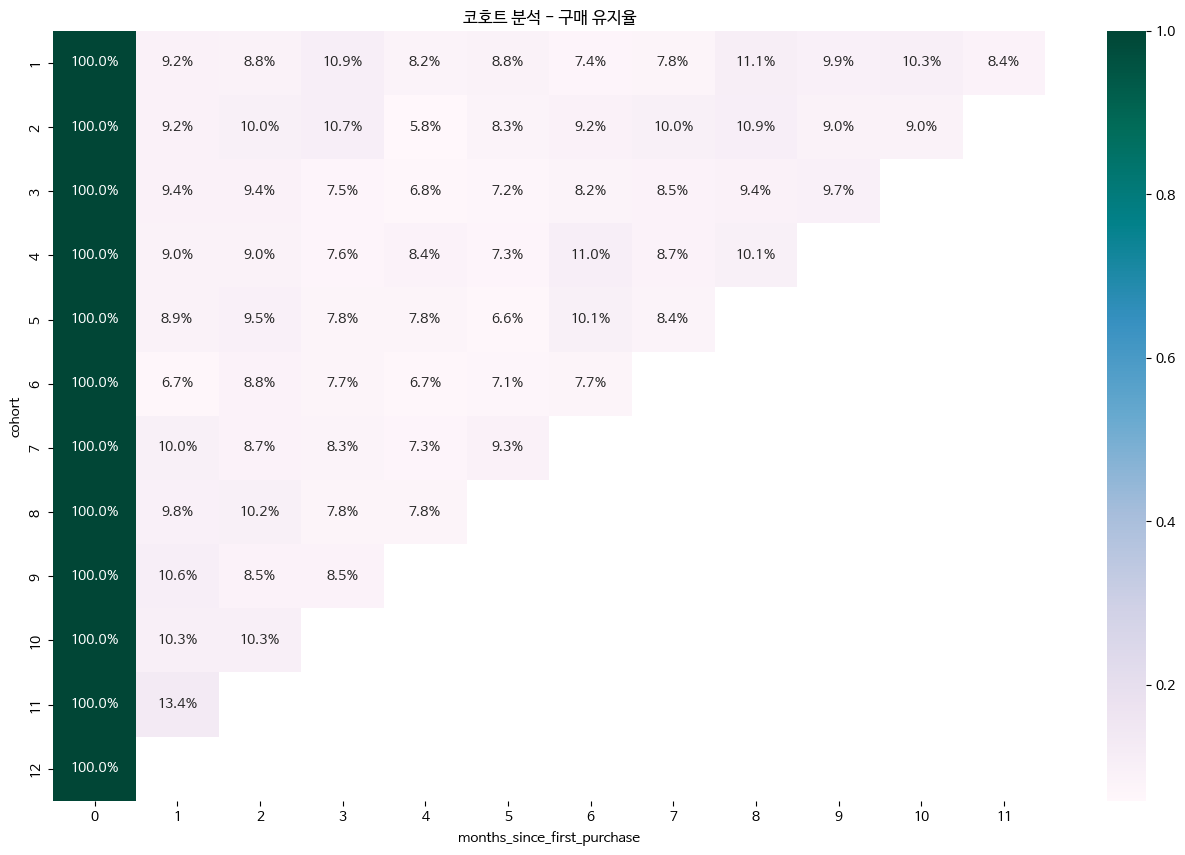

In [61]:
# 코호트와 경과 월수별 구매 유지율 시각화
cohort_heatmap = cohort_data.pivot_table(index='cohort', columns='months_since_first_purchase', values='retention')

plt.figure(figsize=(16, 10))
plt.title('코호트 분석 - 구매 유지율')
sns.heatmap(cohort_heatmap, cmap='PuBuGn', annot=True, fmt='.1%')
plt.show()

### 4.b.ii M+1 구매 유지율

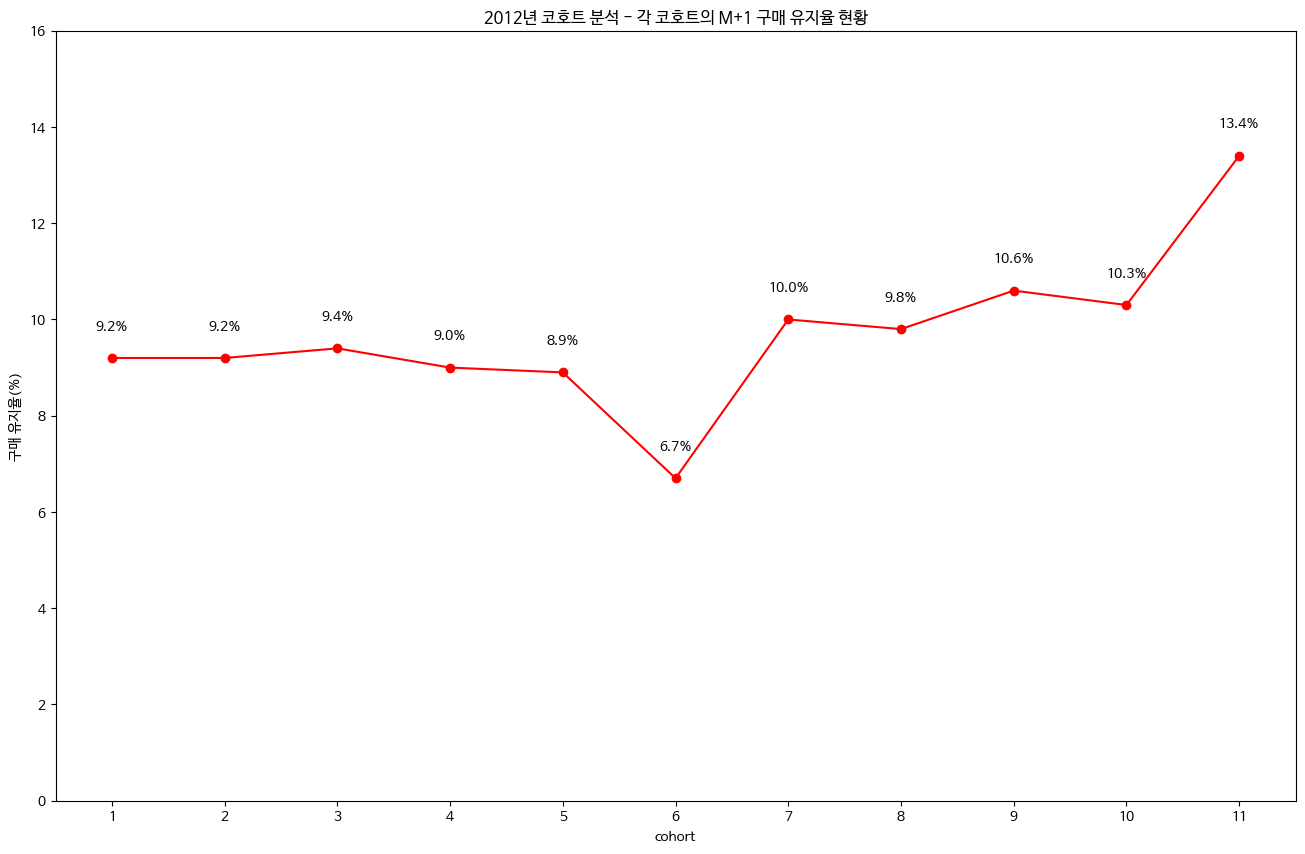

In [62]:
# 각 코호트의 M+1 구매 유지율 현황 계산
M1_cohort = cohort_heatmap[1][:-1].apply(lambda x: round(x*100, 1))

plt.figure(figsize=(16, 10))
M1_cohort.plot(kind='line', color='red', marker='o', label='누적 구성비')

for i, val in enumerate(M1_cohort.values):
    plt.text(M1_cohort.index[i], val+0.5, str(val)+'%', ha='center', va='bottom')

plt.title('2012년 코호트 분석 - 각 코호트의 M+1 구매 유지율 현황')
plt.ylabel('구매 유지율(%)')
plt.xlabel('cohort')

plt.ylim(0, 16)
plt.xticks(np.arange(1,12,1))

plt.show()

**결과해석**

1. 2012년 1~5월까지 M+1 구매 유지율이 약 9% 내외
2. 6월은 6.7%로 연중 최저치 기록
3. 7~10월까지 구매 유지율이 10%를 상회하며 다시 회복
4. 11월 코호트의 경우 연중 최고치 기록

> 해당 코호트 분석결과 2012년 하반기 재구매 증가로 구매 유지율이 크게 개선되었음을 보여준다.<br>이 당시 서비스의 어떤 부분이 이 결과를 이끌어냈는지 분석 필요

---

# **5. RFM 분석**

## 5.a RFM 데이터 전처리

In [63]:
# 2012년 고객 구매 데이터 & 구매확정 데이터
rfm_df = new_data[(new_data['tran_date'] >= '2012-01-01') & (new_data['tran_date'] < '2013-01-01') & (new_data['confirmed'] == 'confirm')].sort_values(['cust_id', 'tran_date'])

# 각 고객의 최신 거래 내역만 추출
# 각 고객의 2012년도 누적 구매건수
# 각 고객의 2012년도 누적 매출액
rfm_df = rfm_df.groupby('cust_id').agg({'tran_date': lambda date: date.max(),
                                    'transaction_id': lambda num: len(num),
                                    'total_amt': lambda price: price.sum()})

# rfm_df 컬럼명을 recency, frequency, monetary로 변경
rfm_df.columns=['recency', 'frequency', 'monetary'] 

## 5.b 2012년 RFM 스코어 분석

### 5.b.i R, F, M Class 부여

* Class는 수는 1등급에서 5등급으로 총 5개의 구간으로 설정
* 고객은 recency가 가장 최근이고, frequency와 monetary가 가장 높은 고객이 1등급 고객이다

In [64]:
# 5개의 그룹으로 R, F, M class를 나누어준다
rfm_df['r_quartile'] = pd.qcut(rfm_df['recency'], 5, ['5','4','3','2','1'])
rfm_df['m_quartile'] = pd.qcut(rfm_df['monetary'], 5, ['5','4','3','2','1'])

# 현 데이터의 frequency의 범위는 1~6로 그 범위가 너무 작기때문에 pd.cut() function을 쓰면 에러가 걸린다
# 그래서 frequency는 임의로 1->5, 2->4, 3->3, 4->2, [5,6]->1으로 구분해준다
rfm_df['f_quartile'] = rfm_df['frequency'].apply(lambda x: 5 if x == 1 else (4 if x == 2 else (3 if x == 3 else (2 if x == 4 else 1))))

### 5.b.ii 가중치 및 RFM 스코어 계산

* RFM 각 요소별 **매출 기여도**에 따른 RFM의 **가중치** 계산
* 가중치를 이용하여 RFM 스코어 계산
    * RFM 스코어가 낮을수록 **우수 고객**

In [65]:
# 기존 cust_id index 원위치
rfm_temp = rfm_df.reset_index()

In [66]:
# Rrecency 그룹을 기준
rfm_r = rfm_temp.groupby('r_quartile').agg({'cust_id': lambda customer: len(customer),
                                            'monetary': lambda price: price.sum()}).sort_index(ascending=False)

# 구성비(고객수/총 고객수) 계산
rfm_r['구성비'] = rfm_r['cust_id'] / rfm_r['cust_id'].sum()

# 매출 구성비(매출액/총 매출액) 계산
rfm_r['매출 구성비'] = rfm_r['monetary'] / rfm_r['monetary'].sum()

# 매출 기여도(매출 구성비 / 구성비) 계산
rfm_r['매출 기여도'] = rfm_r['매출 구성비'] / rfm_r['구성비']

rfm_r

,cust_id,monetary,구성비,매출 구성비,매출 기여도
r_quartile,,,,,
1,731,4039777.235,0.195979,0.252283,1.287300
2,756,3679769.340,0.202681,0.229801,1.133806
3,749,3245758.490,0.200804,0.202697,1.009426
4,740,2702719.500,0.198391,0.168784,0.850764
5,754,2344836.520,0.202145,0.146435,0.724404


In [67]:
# frequency 그룹을 기준
rfm_f = rfm_temp.groupby('f_quartile').agg({'cust_id': lambda customer: len(customer),
                                            'monetary': lambda price: price.sum()}).sort_index(ascending=True)

# 구성비(고객수/총 고객수) 계산
rfm_f['구성비'] = rfm_f['cust_id'] / rfm_f['cust_id'].sum()

# 매출 구성비(매출액/총 매출액) 계산
rfm_f['매출 구성비'] = rfm_f['monetary'] / rfm_f['monetary'].sum()

# 매출 기여도(매출 구성비 / 구성비) 계산
rfm_f['매출 기여도'] = rfm_f['매출 구성비'] / rfm_f['구성비']

rfm_f

,cust_id,monetary,구성비,매출 구성비,매출 기여도
f_quartile,,,,,
1,25,343464.940,0.006702,0.021449,3.200238
2,124,1282182.330,0.033244,0.080072,2.408618
3,415,3345954.365,0.111260,0.208954,1.878070
4,1102,5687931.145,0.295442,0.355210,1.202299
5,2064,5353328.305,0.553351,0.334314,0.604163


In [68]:
# monetary 그룹을 기준
rfm_m = rfm_temp.groupby('m_quartile').agg({'cust_id': lambda customer: len(customer),
                                            'monetary': lambda price: price.sum()}).sort_index(ascending=False)

# 구성비(고객수/총 고객수) 계산
rfm_m['구성비'] = rfm_m['cust_id'] / rfm_m['cust_id'].sum()

# 매출 구성비(매출액/총 매출액) 계산
rfm_m['매출 구성비'] = rfm_m['monetary'] / rfm_m['monetary'].sum()

# 매출 기여도(매출 구성비 / 구성비) 계산
rfm_m['매출 기여도'] = rfm_m['매출 구성비'] / rfm_m['구성비']

rfm_m

,cust_id,monetary,구성비,매출 구성비,매출 기여도
m_quartile,,,,,
1,746,7331856.220,0.200000,0.457873,2.289365
2,746,4096136.655,0.200000,0.255803,1.279015
3,745,2562725.945,0.199732,0.160042,0.801283
4,746,1460526.015,0.200000,0.091210,0.456048
5,747,561616.250,0.200268,0.035073,0.175129


In [69]:
# R 총 매출 기여도
sum_r = rfm_r['매출 기여도'].sum()

# F 총 매출 기여도
sum_f = rfm_f['매출 기여도'].sum()

# M 총 매출 기여도
sum_m = rfm_m['매출 기여도'].sum()

# RFM 매출 기여도 합
sum_total = sum_r + sum_f + sum_m

# R 가중치
weight_r_2012 = sum_r / sum_total

# F 가중치
weight_f_2012 = sum_f / sum_total

# M 가중치
weight_m_2012 = sum_m / sum_total

print('R 가중치: ', weight_r_2012)
print('F 가중치: ', weight_f_2012)
print('M 가중치: ', weight_m_2012)

R 가중치:  0.2593636730371362
F 가중치:  0.48152452442615395
M 가중치:  0.25911180253670985


In [ ]:
# 각 RFM quartile에 가중치를 곱한 후 합을 구해 RFM SCORE 계산
rfm_df['RFM SCORE'] = round((weight_r_2012 * rfm_df['r_quartile'].astype(int)) + (weight_f_2012 * rfm_df['f_quartile'].astype(int)) + (weight_m_2012 * rfm_df['m_quartile'].astype(int)),2)
rfm_df.sort_values('RFM SCORE', ascending=True)

## 5.c 2012년 vs 2013년 RFM SCORE 비교

In [71]:
# 2012년 RFM 데이터 가져오기
rfm_2012 = rfm_df.copy()

In [72]:
# 2013년 RFM 데이터 가져오기 (방법은 전 섹션에서 구한 방법과 동일)

# 2013년 고객 구매 데이터 & 구매확정 데이터
rfm_2013 = new_data[(new_data['tran_date'] >= '2013-01-01') & (new_data['tran_date'] < '2014-01-01') & (new_data['confirmed'] == 'confirm')].sort_values(['cust_id', 'tran_date'])

# 각 고객의 최신 거래 내역만 추출
# 각 고객의 2013년도 누적 구매건수
# 각 고객의 2013년도 누적 매출액
rfm_2013 = rfm_2013.groupby('cust_id').agg({'tran_date': lambda date: date.max(),
                                    'transaction_id': lambda num: len(num),
                                    'total_amt': lambda price: price.sum()})

# rfm_2013 컬럼명을 recency, frequency, monetary로 변경
rfm_2013.columns=['recency', 'frequency', 'monetary'] 

# 5개의 그룹으로 R, F, M class를 나누어준다
rfm_2013['r_quartile'] = pd.qcut(rfm_2013['recency'], 5, ['5','4','3','2','1'])
rfm_2013['m_quartile'] = pd.qcut(rfm_2013['monetary'], 5, ['5','4','3','2','1'])

# 현 데이터의 frequency의 범위는 1~6로 그 범위가 너무 작기때문에 pd.cut() function을 쓰면 에러가 걸린다
# 그래서 frequency는 임의로 1->5, 2->4, 3->3, 4->2, [5,6]->1으로 구분해준다
rfm_2013['f_quartile'] = rfm_2013['frequency'].apply(lambda x: 5 if x == 1 else (4 if x == 2 else (3 if x == 3 else (2 if x == 4 else 1))))

# 기존 cust_id index 원위치
rfm_temp = rfm_2013.reset_index()

# Rrecency 그룹을 기준
rfm_r = rfm_temp.groupby('r_quartile').agg({'cust_id': lambda customer: len(customer),
                                            'monetary': lambda price: price.sum()}).sort_index(ascending=False)

# 구성비(고객수/총 고객수) 계산
rfm_r['구성비'] = rfm_r['cust_id'] / rfm_r['cust_id'].sum()

# 매출 구성비(매출액/총 매출액) 계산
rfm_r['매출 구성비'] = rfm_r['monetary'] / rfm_r['monetary'].sum()

# 매출 기여도(매출 구성비 / 구성비) 계산
rfm_r['매출 기여도'] = rfm_r['매출 구성비'] / rfm_r['구성비']

# frequency 그룹을 기준
rfm_f = rfm_temp.groupby('f_quartile').agg({'cust_id': lambda customer: len(customer),
                                            'monetary': lambda price: price.sum()}).sort_index(ascending=True)

# 구성비(고객수/총 고객수) 계산
rfm_f['구성비'] = rfm_f['cust_id'] / rfm_f['cust_id'].sum()

# 매출 구성비(매출액/총 매출액) 계산
rfm_f['매출 구성비'] = rfm_f['monetary'] / rfm_f['monetary'].sum()

# 매출 기여도(매출 구성비 / 구성비) 계산
rfm_f['매출 기여도'] = rfm_f['매출 구성비'] / rfm_f['구성비']

# monetary 그룹을 기준
rfm_m = rfm_temp.groupby('m_quartile').agg({'cust_id': lambda customer: len(customer),
                                            'monetary': lambda price: price.sum()}).sort_index(ascending=False)

# 구성비(고객수/총 고객수) 계산
rfm_m['구성비'] = rfm_m['cust_id'] / rfm_m['cust_id'].sum()

# 매출 구성비(매출액/총 매출액) 계산
rfm_m['매출 구성비'] = rfm_m['monetary'] / rfm_m['monetary'].sum()

# 매출 기여도(매출 구성비 / 구성비) 계산
rfm_m['매출 기여도'] = rfm_m['매출 구성비'] / rfm_m['구성비']

# R 총 매출 기여도
sum_r = rfm_r['매출 기여도'].sum()

# F 총 매출 기여도
sum_f = rfm_f['매출 기여도'].sum()

# M 총 매출 기여도
sum_m = rfm_m['매출 기여도'].sum()

# RFM 매출 기여도 합
sum_total = sum_r + sum_f + sum_m

# R 가중치
weight_r_2013 = sum_r / sum_total

# F 가중치
weight_f_2013 = sum_f / sum_total

# M 가중치
weight_m_2013 = sum_m / sum_total

# 각 RFM quartile에 가중치를 곱한 후 합을 구해 RFM SCORE 계산
rfm_2013['RFM SCORE'] = round((weight_r_2013 * rfm_2013['r_quartile'].astype(int)) + (weight_f_2013 * rfm_2013['f_quartile'].astype(int)) + (weight_m_2013 * rfm_2013['m_quartile'].astype(int)),2)

In [73]:
# 2012년 RFM 데이터와 2013년 RFM SCORE를 통합
merged_rmf = pd.merge(rfm_2012, rfm_2013, on='cust_id', how='outer', suffixes=(' 2012', ' 2013'))

# 2012년 RMF과 2013년 RMF의 차이 계산
merged_rmf['changes'] = merged_rmf['RFM SCORE 2012'] - merged_rmf['RFM SCORE 2013']

In [ ]:
merged_rmf[merged_rmf['changes'] < 0]